# <center> Projet :  Moteur de classiffication </center>



<img src="https://www.affacturage.fr/img/produits/place-de-marche-marketplace.jpg" width=492>


### <center>Thème : Marketplace </center>
### <center>https://openclassrooms.com/fr/paths/164/projects/631/assignment<center>

# Mission du notebook

Bonjour, 

Merci pour ton aide sur ce projet !

Ta mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

Tu dois analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering. Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters. Ces résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

Pourrais-tu nous démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des produits de même catégorie ?

Voici les contraintes : 

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 
 

En pièce jointe, tu trouveras un exemple de mise en œuvre de ces approches sur un autre dataset. Je t’invite à l’utiliser comme point de départ, cela va te faire gagner beaucoup de temps !

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.

Merci encore, 

Linda

P.S. : j’insiste sur le fait qu’on n’a pas besoin d’un moteur de classification supervisée à ce stade, mais bien d’une étude de faisabilité !

In [1]:
#Data management/data viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


#Statistiques/ML
import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score # score recall
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    adjusted_rand_score as ari
)
from scipy.cluster.hierarchy import fcluster, linkage
import scipy

#Image
from PIL import Image
from IPython.display import  display
from PIL import ImageFilter
import cv2 
from matplotlib.image import imread

#Texte
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

#Autre
import time
import os
#Afficher toute les colonnes
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)




# Data Management

Chargeons le jeu de données;

In [2]:
df=pd.read_csv("E_commerce.csv")
os.chdir(os.getcwd()+"/Images")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [3]:
print(df.shape)

(1050, 15)


On a 1050 biens de consommations regrouppés en 15 caractéristiques.

In [4]:
df.product_category_tree.value_counts()

["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                                                                                                                56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                                                                                                                  26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                                                                                                         23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                                                                                                                22
["Watches >> Wrist Watches >> Sonata Wrist Watches"]                                                                                                                         19
                                                                                                                        

Les catégories sont trop diversifiées et notre jeu de données est petit. Nous allons allégé les catégories.

In [5]:
categorie =df.product_category_tree[0].split(" >>")[0]
categorie =categorie.replace("[", "")
categorie =categorie.replace("''", "")
categorie=categorie.replace("\"", "")
categorie

'Home Furnishing'

In [6]:
def target(categorie):
    """Creation catégorie des articles"""
    categorie =categorie.split(" >>")[0]
    categorie =categorie.replace("[", "")
    categorie =categorie.replace("''", "")
    categorie=categorie.replace("\"", "")
    return(categorie)
    
target(df.product_category_tree[0])    
target(df.product_category_tree[30])    

'Watches'

In [7]:
df["categorie_article"]=0

df["categorie_article"]=df["product_category_tree"].apply(lambda x: target(x))
df["categorie_article"].value_counts()

Computers                     150
Home Furnishing               150
Watches                       150
Beauty and Personal Care      150
Baby Care                     150
Kitchen & Dining              150
Home Decor & Festive Needs    150
Name: categorie_article, dtype: int64

On a 7 catégories d'articles avec 150 échantillons chacun.

Les données images sont récupérables à partir de la colonne image.

In [8]:
df["image"][1]

'7b72c92c2f6c40268628ec5f14c6d590.jpg'

Les données textes sont dans la colonne description. Ils correspondent à la description du produit.

In [9]:
df["product_url"][1]

'http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH'

In [10]:
df["description"][1]

'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

# Partie Image

Dans cette partie, nous étudierons la faisabilité d'un moteur de classiffication en utilisant uniquement les images des articles de notre échantillon.

### Pré-processing

Manipulation des images et créations d'un dataset.

In [11]:
df_image=df[["categorie_article","image"]]
df_image["image_propre"]=df.index
df_image["image_propre"]=df_image["image_propre"].apply(lambda x: str(x)+".jpg")
df_image.head()

<ipython-input-11-aed7f68bde15>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_image["image_propre"]=df.index
<ipython-input-11-aed7f68bde15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_image["image_propre"]=df_image["image_propre"].apply(lambda x: str(x)+".jpg")


,categorie_article,image,image_propre
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,0.jpg
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,1.jpg
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,2.jpg
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,3.jpg
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,4.jpg


In [12]:
exemple_Watch=[index for index, value in enumerate(list(df_image["categorie_article"]=="Watches")) if value == 1][:3]
exemple_Baby=[index for index, value in enumerate(list(df_image["categorie_article"]=="Baby Care")) if value == 1][:3]
exemple_Computer=[index for index, value in enumerate(list(df_image["categorie_article"]=="Computers")) if value == 1][:3]

Baby Care


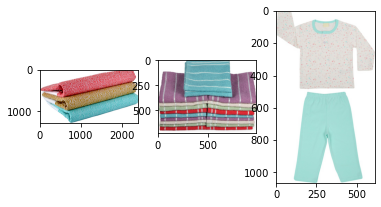

Computer


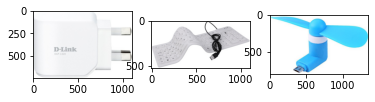

Watches


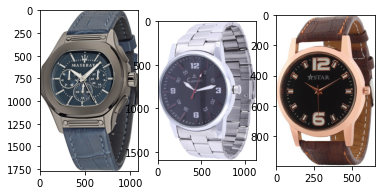

In [13]:
print("Baby Care")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Baby[i],"image"]))
plt.show()
print("Computer")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Computer[i],"image"]))
plt.show()
print("Watches")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Watch[i],"image"]))
plt.show()


In [14]:
for i in range(len(df_image.image)):
    image = cv2.imread(df_image.image[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    nom=str(i)
    cv2.imwrite(str(nom)+".jpg", image) 

Baby Care


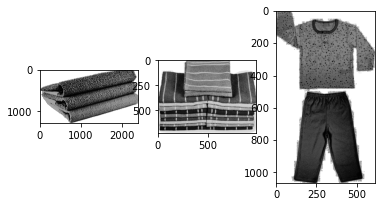

Computer


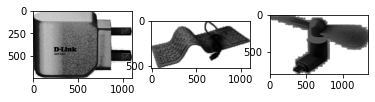

Watches


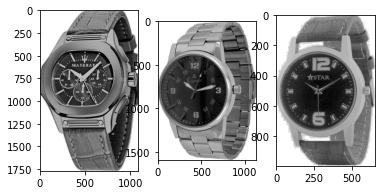

In [15]:
print("Baby Care")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Baby[i],"image_propre"]),cmap='gray')
plt.show()
print("Computer")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Computer[i],"image_propre"]),cmap='gray')
plt.show()
print("Watches")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Watch[i],"image_propre"]),cmap='gray')
plt.show()

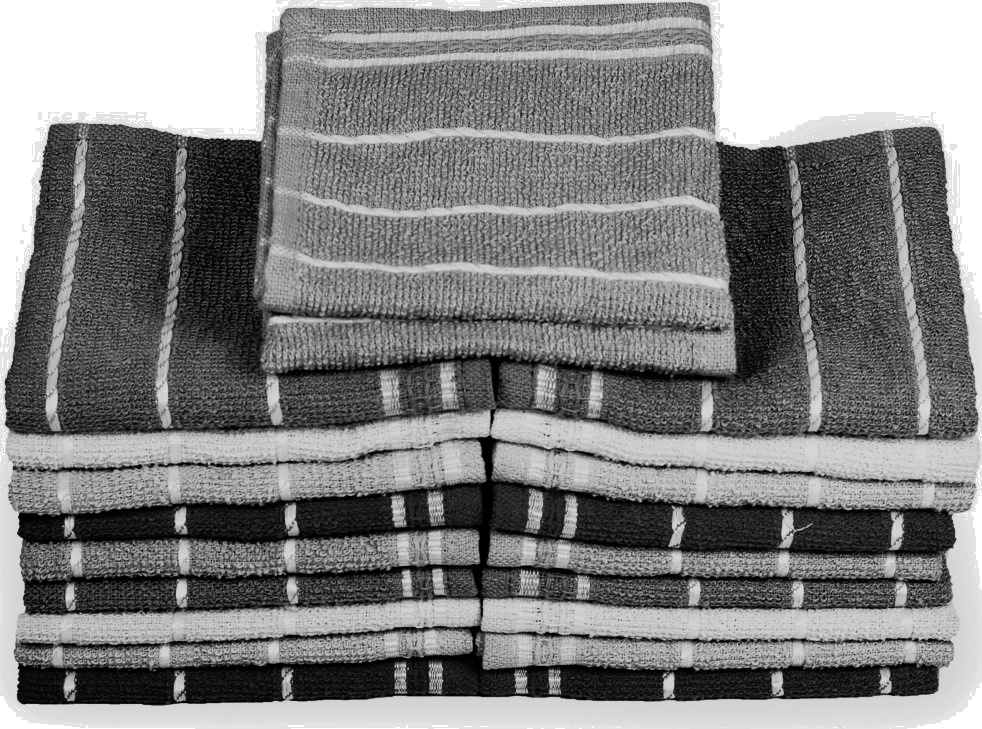

Taille de la matrice de pixels : (729, 982)


In [16]:
#exemple d'image
img = Image.open("2.jpg") 
display(img)
mat = np.array(img)
print("Taille de la matrice de pixels : {}".format(mat.shape))

### Approche SIFT

L'algorithme SIFT (Scale-invariant feature transform). Cette méthode, développée en 1999 et très populaire dans le domaine de la vision par ordinateur, permet d'extraire des features (ou points d'intérêt) de l'image et de calculer leurs descripteurs. 

##### Création des descripteurs et des clusteurs

On a 500 features.


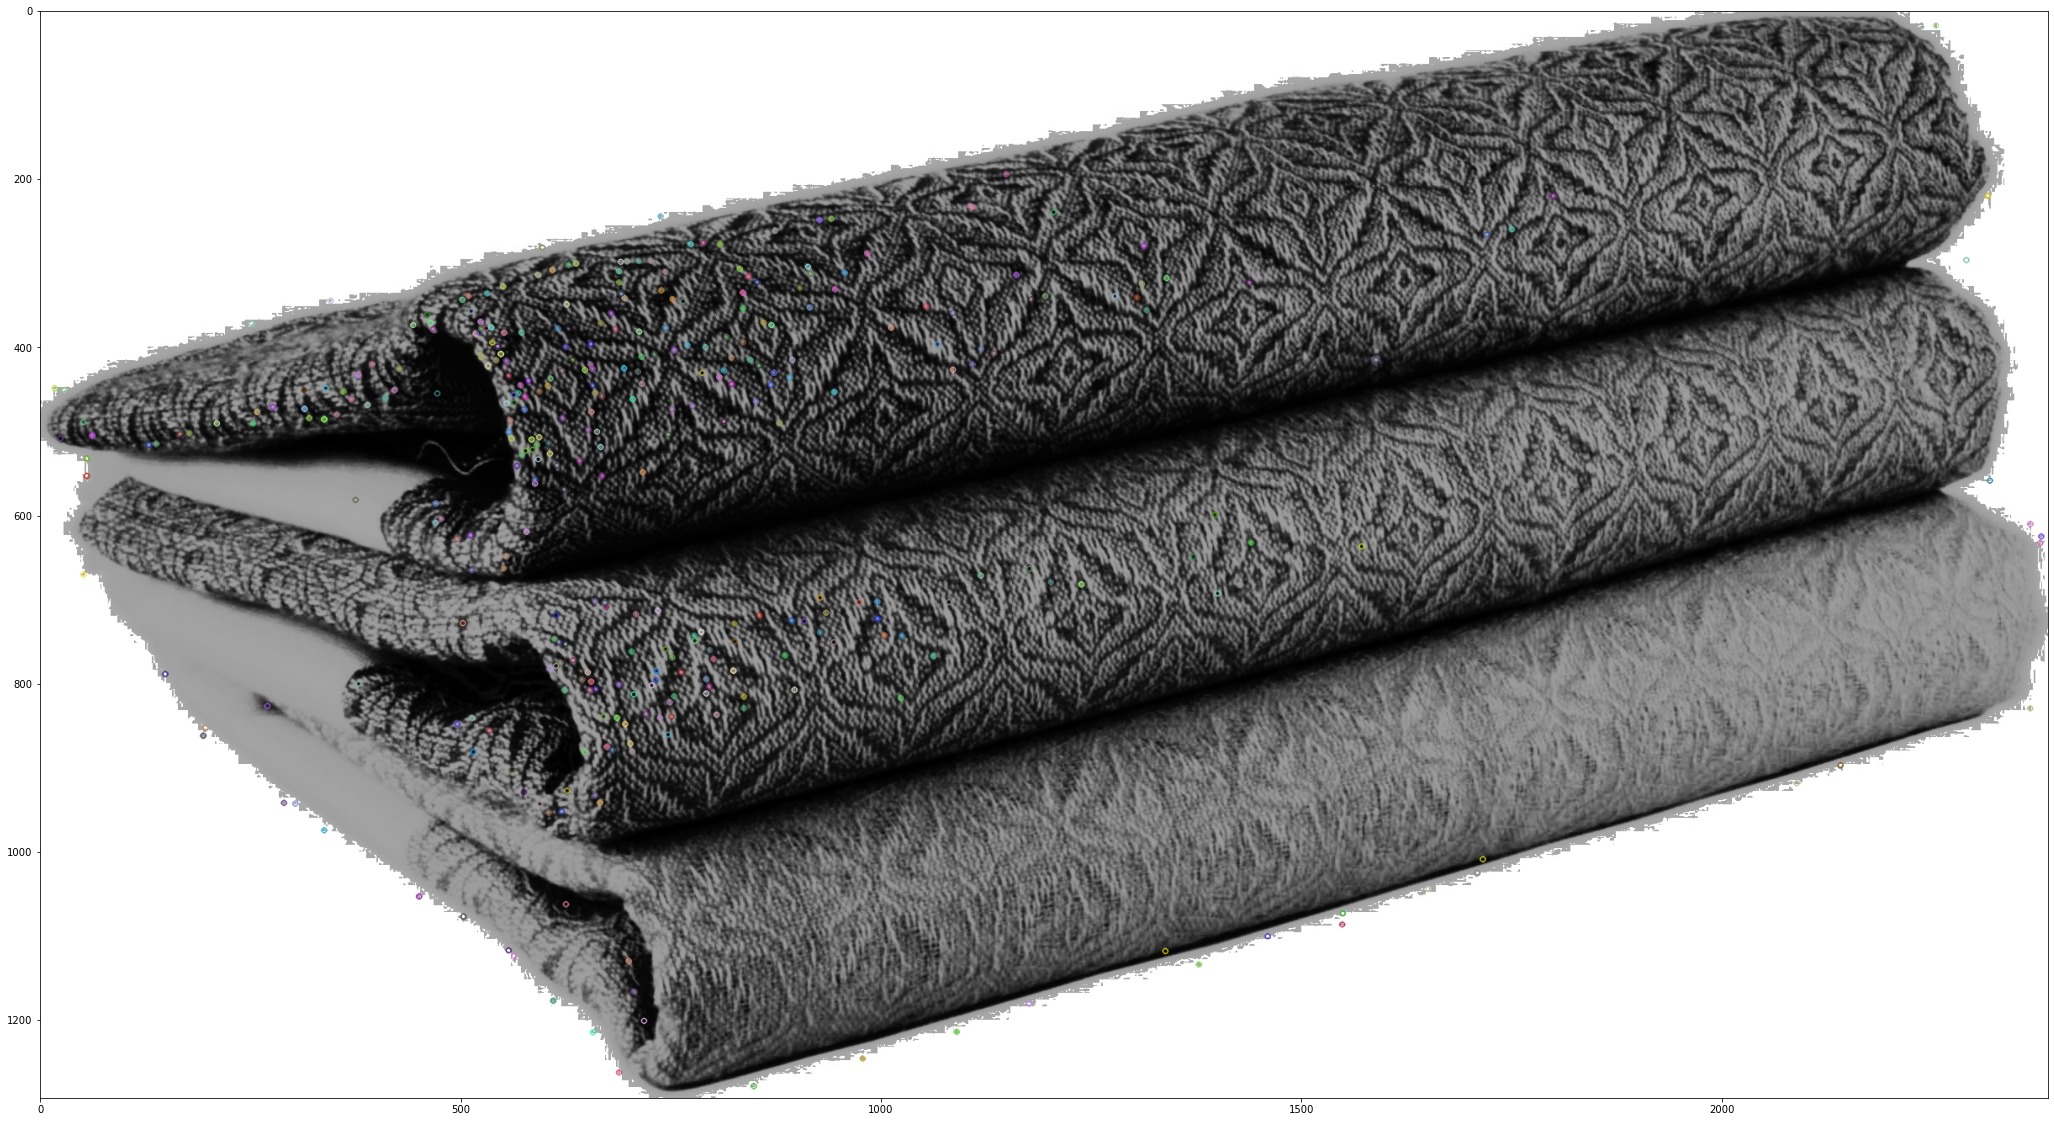

In [17]:
#SIFT_create prend en argument le nombre de features que l'on souhaite avoir
test=imread("1.jpg")
sift = cv2.xfeatures2d.SIFT_create(500) # Ce choix est-il arbitraire ?
kp=sift.detect(test,None)
print("On a",len(kp),"features.")
gray=cv2.drawKeypoints(test,kp,None)
plt.figure(figsize = (50,20))
plt.imshow(gray)

##### Réduction de dimension

##### Analyse visuelle et ARI

### Approche CNN

# Partie Texte

Dans cette partie, nous étudierons la faisabilité d'un moteur de classiffication en utilisant uniquement les descriptions des articles de notre échantillon.

### Pré-processing

In [18]:
test=df["description"][1]
test


'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

In [19]:
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2


test=stop_word_filter_fct(tokenizer_fct(test))
test

['Specifications',
 'Sathiyas',
 'Cotton',
 'Bath',
 'Towel',
 'Bath',
 'Towel',
 'Red',
 'Yellow',
 'Blue',
 'Bath',
 'Towel',
 'Features',
 'Machine',
 'Washable',
 'Yes',
 'Material',
 'Cotton',
 'Design',
 'Self',
 'Design',
 'General',
 'Brand',
 'Sathiyas',
 'Type',
 'Bath',
 'Towel',
 'GSM',
 '500',
 'Model',
 'Name',
 'Sathiyas',
 'cotton',
 'bath',
 'towel',
 'Ideal',
 'For',
 'Men',
 'Women',
 'Boys',
 'Girls',
 'Model',
 'asvtwl322',
 'Color',
 'Red',
 'Yellow',
 'Blue',
 'Size',
 'Mediam',
 'Dimensions',
 'Length',
 'inch',
 'Width',
 'inch',
 'Box',
 'Number',
 'Contents',
 'Sales',
 'Package',
 'Sales',
 'Package',
 'Bath',
 'Towel']

### Approche bag of word comptage mot

In [20]:
pd.value_counts(test)

Bath              5
Towel             5
Sathiyas          3
Sales             2
Yellow            2
Package           2
Red               2
Blue              2
Model             2
inch              2
Cotton            2
Design            2
Men               1
towel             1
Mediam            1
Brand             1
Contents          1
Width             1
Dimensions        1
Self              1
Women             1
Type              1
GSM               1
General           1
Washable          1
Ideal             1
Features          1
Length            1
asvtwl322         1
Yes               1
Number            1
Color             1
Size              1
bath              1
Machine           1
For               1
Box               1
cotton            1
Name              1
Girls             1
500               1
Boys              1
Material          1
Specifications    1
dtype: int64

### Approche bag of word Tf-idf

### Approche Word2Vec 

### Approche BERT

### Approche USE

# Conclusion

Remarque 1 : Les catégories que nous avons utilisés sont très général pour la catégorie 'computer', cela peut autant être un clavier qu'une clé usb. Il faudrait pour l'étape de production augmenter le nombre de catégorie et donc aussi le nombre d'images.